In [1]:
# !pip3 install boto3

In [2]:
# This code downloads the coco dataset from Amazon S3 in parallel.
# import boto3
# from botocore import UNSIGNED
# from botocore.client import Config
# import multiprocessing
# import subprocess
# files = ['val2017.zip', 'annotations_trainval2017.zip']

# s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
# def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
#     print("Downloading", file_name)
#     s3.download_file(bucket_name, file_name, file_name)
#     print("Finished downloading", file_name, ". Starting to unzip.")
#     subprocess.run(["unzip", file_name])
#     print("Finished unzipping", file_name)

# # Download in parallel
# num_cpus = multiprocessing.cpu_count()
# with multiprocessing.Pool(num_cpus) as p:
#     p.map(download_and_unzip_from_s3, files)

# print("Done transferring all datasets")

In [3]:
from pycocotools.coco import COCO
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
from PIL import Image

In [4]:
def get_inference(img_path, category):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 
  device = torch.device("cuda:0" if torch.cuda.is_available() else cpu)
  model = model.to(device)
  model.eval()
  
  img = Image.open(img_path)

  img_tensor = torch.tensor(np.asarray(img)).permute(2,0,1).unsqueeze(0)
  img_tensor = img_tensor.float()/255.0 
  img_tensor = img_tensor.to(device)

  with torch.no_grad():
    pred = model(img_tensor)

  pred_indices = [i for i, x in enumerate(pred[0]['labels'] ) if x == category]
  pred_boxes = pred[0]['boxes'][pred_indices].int().cpu().numpy()
  pred_score = list(pred[0]['scores'][pred_indices].cpu().numpy())

  return pred_indices, pred_boxes, pred_score

In [5]:
def object_detector(img_path, category, threshold):
  indices, boxes, scores = get_inference(img_path, category)

  for i in range(len(boxes)):
    if scores[i] > threshold:
      print('bounding box',boxes[i])
      print('score',scores[i])
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      x,y,w,h = boxes[i]

      img = cv2.rectangle(img, (x, y),(w,h), (36,255,12), 1)
      cv2.putText(img, 'Person', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
      
      plt.figure(figsize=(10,8)) 
      plt.imshow(img) 
      plt.xticks([]) 
      plt.yticks([]) 
      plt.show()

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
000000351810.jpg


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


bounding box [ 18 107 110 285]
score 0.99298006


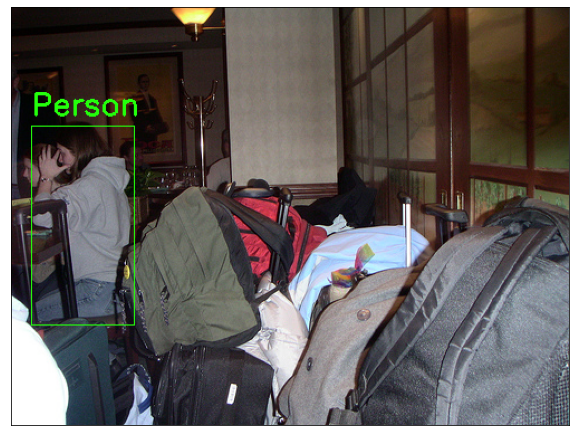

bounding box [  0  51  46 164]
score 0.92999417


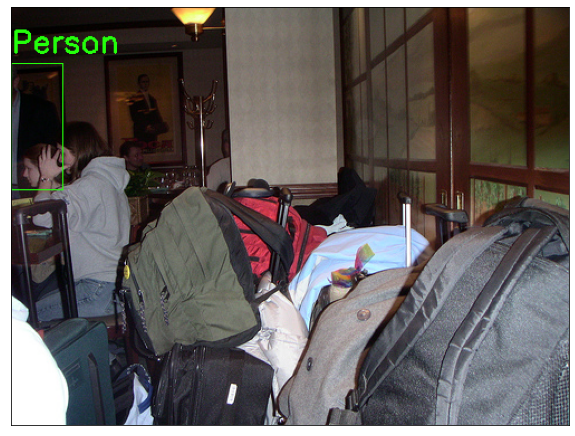

bounding box [  4 123  56 169]
score 0.8514854


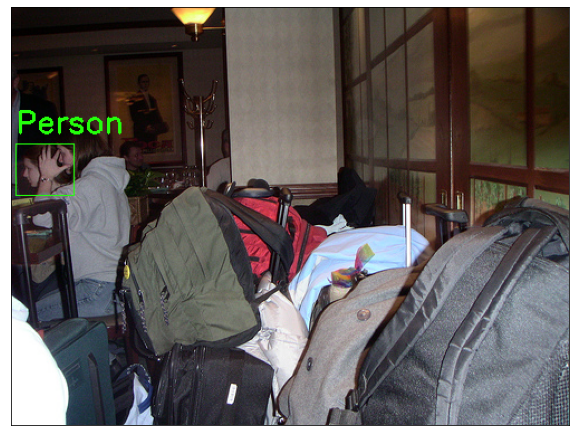

bounding box [ 97 120 123 150]
score 0.7606745


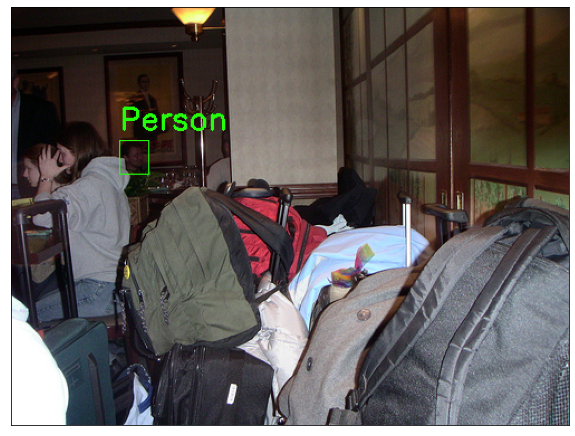

000000419408.jpg
bounding box [224 109 363 275]
score 0.9997384


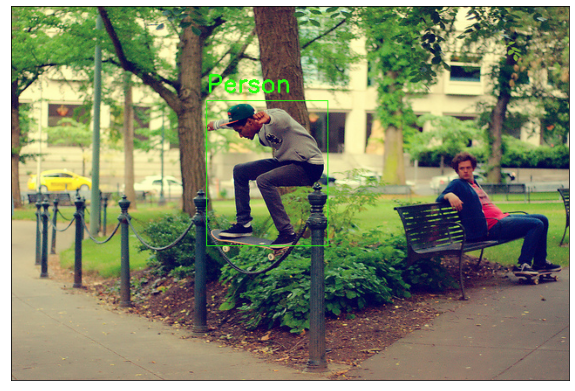

bounding box [487 171 629 306]
score 0.9984983


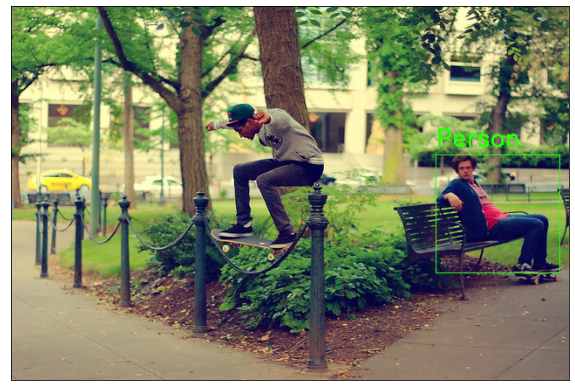

In [6]:
dataDir = '/content'
dataType = 'val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
catID = coco.getCatIds(catNms='person')
imgIds = coco.getImgIds(catIds=catID)

images = random.sample(imgIds,2)

for img_id in coco.loadImgs(images):
  file_name = img_id['file_name']
  print(file_name)
  img_path = dataDir + '/' + dataType + '/' + file_name

  object_detector(img_path, catID[0], threshold=0.7)